# Fidelity Optimization Based on QuCT

**Author:** Congliang Lang & Siwei Tan  

**Date:** 7/4/2024

Based on paper "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features][1]" (MICRO 2023)

[1]: https://dl.acm.org/doi/10.1145/3613424.3614274

The accurate fidelity prediction enables QuCT to guide the noise optimization. In this notebook, we introduce the optimization strategies.

In [1]:
import os
os.chdir("../..")
import logging
logging.basicConfig(level=logging.WARN)

import random
import ray
ray.init(log_to_driver=False)

from janusq.objects.random_circuit import random_circuits
from janusq.objects.backend import FullyConnectedBackend
from janusq.analysis.vectorization import RandomwalkModel
from janusq.analysis.fidelity_prediction import FidelityModel
from janusq.simulator.gate_error_model import GateErrorModel
from janusq.simulator.noisy_simulator import NoisySimulator
from janusq.tools.ray_func import map

2025-02-08 11:00:00,341	INFO worker.py:1724 -- Started a local Ray instance.


In [2]:
# build a simulator

n_qubits = 5
n_steps = 1
n_walks = 20
backend = FullyConnectedBackend(n_qubits)

circuits = random_circuits(backend, n_circuits=50, n_gate_list=list(range(10, 150, 10)), two_qubit_prob_list=[0.3, 0.4, 0.6], reverse=True)
up_model = RandomwalkModel(n_steps = n_steps, n_walks = n_walks, backend = backend)
up_model.train(circuits, multi_process=False, remove_redundancy = False)

all_paths = up_model.all_paths()
high_error_paths = random.choices(all_paths, k = 20)

error_model = GateErrorModel.random_model(backend=backend, high_error_paths=high_error_paths)
error_model.vec_model = up_model

simulator = NoisySimulator(backend=backend, gate_error_model = error_model)

100%|██████████| 84/84 [00:01<00:00, 44.09it/s] 


In [3]:
# train a fidelity model
ground_truth_fidelities = map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], circuits, show_progress=False, multi_process=False)

fidelity_model = FidelityModel(up_model)
fidelity_model.train((circuits, ground_truth_fidelities))

67it [00:00, 826524.61it/s]
17it [00:00, 87274.38it/s]


epoch: 100, 	 epoch loss = 9.463730812072754, 	 validation loss = 0.5332390069961548
epoch: 200, 	 epoch loss = 2.3650245666503906, 	 validation loss = 0.2983757555484772
finish taining with 293 epoch


{'circuit_bias': Array([-12.311683], dtype=float32),
 'gate_params': Array([[8.33579826e+00, 4.70527124e+00, 7.48498082e-01, 5.94867468e+00,
         1.51086056e+00, 3.70859861e+00, 4.11591721e+00, 9.00371134e-01,
         4.11027479e+00, 5.23336792e+00, 5.23372555e+00, 2.41510201e+00,
         1.91800606e+00, 4.01583385e+00, 1.63241708e+00, 1.18407078e+01,
         8.94400406e+00, 1.10913458e+01, 1.04254456e+01, 5.24967003e+00,
         9.31919479e+00, 8.36327362e+00, 1.07229519e+01, 8.30880642e+00,
         6.92525148e+00, 1.10803528e+01, 4.66235971e+00, 2.17081547e+00,
         1.04598532e+01, 9.52064753e-01, 6.85901165e+00, 1.20747471e+01,
         1.00805521e+01, 1.01291389e+01, 2.93418241e+00, 5.01366854e+00,
         9.78184891e+00, 8.59428120e+00, 9.29835510e+00, 8.60708904e+00,
         7.20987606e+00],
        [4.68869060e-01, 1.37573123e-01, 4.42455244e+00, 6.67117596e+00,
         3.70861435e+00, 4.70719004e+00, 2.99908209e+00, 6.94288135e-01,
         5.11833096e+00, 2.416

In [4]:
from janusq.objects.algorithms import get_algorithm_circuits
from janusq.optimization.scheduling.scheduling_ct import Scheduler

# generate a set of benchmarking circuits
algs = ['qft', 'hs', 'ising', 'qknn', 'qsvm', 'vqc', 'grover']
benchmarking_circuits = get_algorithm_circuits(n_qubits, backend, algs)

/Users/chutianyao/anaconda3/envs/janusq/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chutianyao/anaconda3/envs/janusq/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


## Scheduling

We can use Janus-CT to guide the scheduling.

In [5]:
scheduler = Scheduler(fidelity_model)

baseline_fidelities, opt_fidelities = [], []
for circuit in benchmarking_circuits:
    baseline_fidelities.append(simulator.obtain_circuit_fidelity(circuit)[0])
    
    opt_circuit = scheduler.run(circuit, timeout=60)
    opt_fidelity = simulator.obtain_circuit_fidelity(opt_circuit)[0]
    
    opt_fidelities.append(opt_fidelity)
    print('before scheduling: ', baseline_fidelities[-1], 'after scheduling: ', opt_fidelities[-1])

before scheduling:  0.9605322247712037 after scheduling:  0.97374506762734
before scheduling:  0.9836962280623418 after scheduling:  0.9835787087103484
before scheduling:  0.9487587116201699 after scheduling:  0.983164334191766
before scheduling:  0.9430294315267226 after scheduling:  0.9601354092080708
before scheduling:  0.9660965928695326 after scheduling:  0.9626671979169927
before scheduling:  0.8987987440137623 after scheduling:  0.89105835878593
before scheduling:  0.8383853475948918 after scheduling:  0.9309604583046649


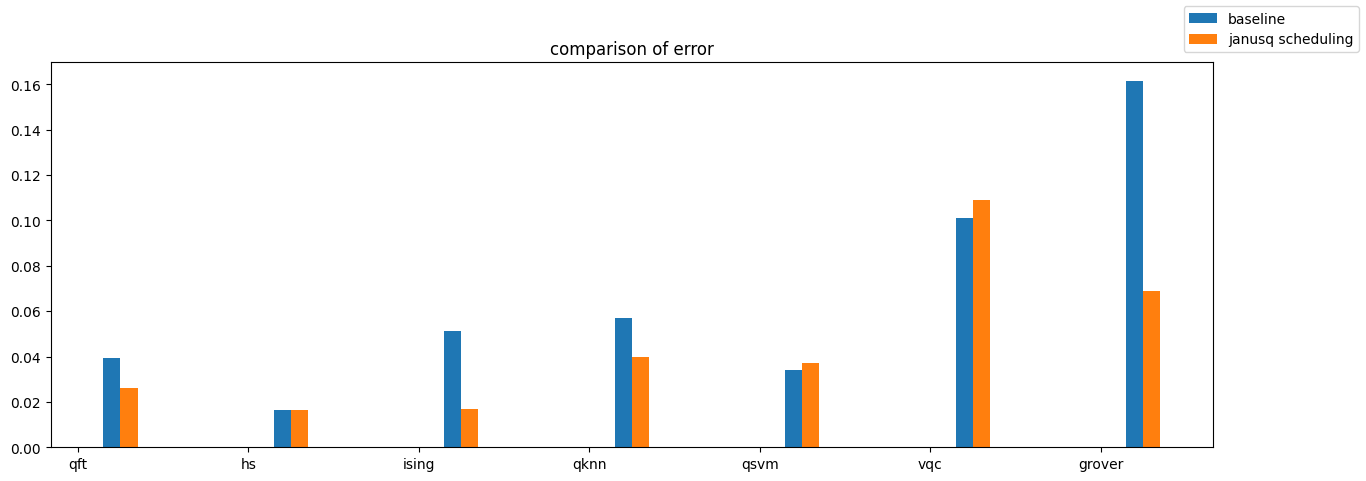

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(figsize=(15, 5))
x = [i for i in range(len(benchmarking_circuits))]
x = np.array(x) * 20
# axes.bar(x,reals_baseline,width =2,label='reals_baseline')

baseline_fidelities = np.array(baseline_fidelities)
opt_fidelities = np.array(opt_fidelities)
axes.bar(x+4,1-baseline_fidelities,width =2,label='baseline')
axes.bar(x+6,1-opt_fidelities,width =2,label='janusq scheduling')

plt.title('comparison of error')
axes.set_xticks(x)
axes.set_xticklabels(algs)
fig.legend()